In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os
print(os.listdir("../CNN"))

Using TensorFlow backend.


['.ipynb_checkpoints', 'CatVsDog.ipynb', 'submission.csv', 'test1', 'train']


In [2]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

In [3]:
filenames = os.listdir("../CNN/train/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [4]:


df.head()



,filename,category
0,cat.4519.jpg,0
1,cat.452.jpg,0
2,cat.4520.jpg,0
3,cat.4521.jpg,0
4,cat.4522.jpg,0


In [5]:


df.tail()



,filename,category
18583,dog.9995.jpg,1
18584,dog.9996.jpg,1
18585,dog.9997.jpg,1
18586,dog.9998.jpg,1
18587,dog.9999.jpg,1


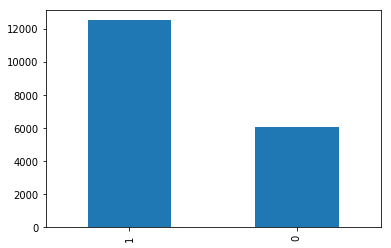

In [6]:

#See Total In count¶

df['category'].value_counts().plot.bar()



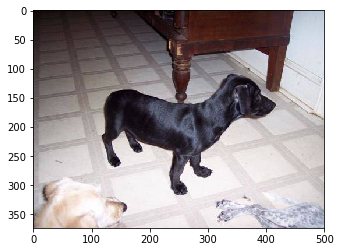

In [7]:

#See sample image

sample = random.choice(filenames)
image = load_img("../CNN/train/train/"+sample)
plt.imshow(image)



MODEL

    Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
    Conv Layer: This layer will extract features from image.
    Pooling Layer: This layerreduce the spatial volume of input image after convolution.
    Fully Connected Layer: It connect the network from a layer to another layer
    Output Layer: It is the predicted values layer.



In [8]:


from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()



W0904 20:15:30.218670 12732 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0904 20:15:30.233658 12732 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0904 20:15:30.235626 12732 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0904 20:15:30.256600 12732 deprecation_wrapper.py:119] From C:\Users\shrey\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0904 20:15:30.257566 12732 deprecation_wrapper.py:119] 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [9]:

#Callbacks

from keras.callbacks import EarlyStopping, ReduceLROnPlateau



In [10]:


#Early Stop

#To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

earlystop = EarlyStopping(patience=10)



In [11]:


#Learning Rate Reduction

#We will reduce the learning rate when then accuracy not increase for 2 steps

learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)



In [12]:
callbacks = [earlystop, learning_rate_reduction]


Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat


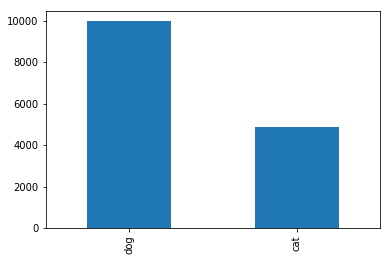

In [13]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

train_df['category'].value_counts().plot.bar()



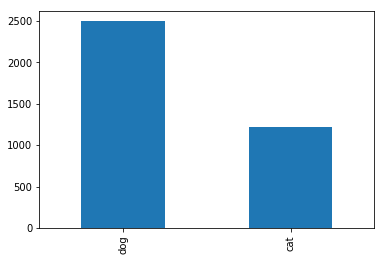

In [14]:


validate_df['category'].value_counts().plot.bar()



In [15]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [31]:

#Traning Generator
'''Generate batches of tensor image data with real-time data augmentation.
The data will be looped over (in batches).'''

train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "../CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 14870 validated image filenames belonging to 2 classes.


In [17]:

#Validation Generator

validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "../CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)



Found 3718 validated image filenames belonging to 2 classes.


In [18]:

#See how our generator work

example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "../CNN/train/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)



Found 1 validated image filenames belonging to 1 classes.


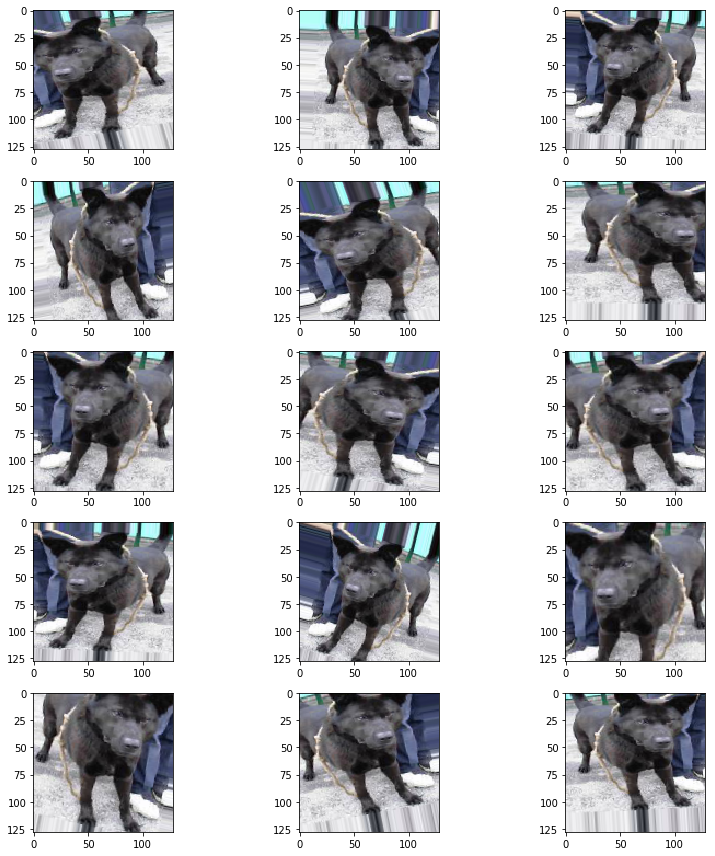

In [19]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [20]:

#Fit Model

epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)



W0904 20:15:33.562136 12732 deprecation.py:323] From C:\Users\shrey\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
991/991 [==============================] - 1172s 1s/step - loss: 0.7539 - acc: 0.6455 - val_loss: 0.6841 - val_acc: 0.6896
Epoch 2/50
991/991 [==============================] - 1107s 1s/step - loss: 0.5654 - acc: 0.7160 - val_loss: 0.5402 - val_acc: 0.7248
Epoch 3/50
991/991 [==============================] - 1100s 1s/step - loss: 0.5325 - acc: 0.7362 - val_loss: 0.4713 - val_acc: 0.7794
Epoch 4/50
991/991 [==============================] - 1134s 1s/step - loss: 0.5036 - acc: 0.7595 - val_loss: 0.4519 - val_acc: 0.7888
Epoch 5/50
991/991 [==============================] - 1257s 1s/step - loss: 0.4725 - acc: 0.7767 - val_loss: 0.5203 - val_acc: 0.7497
Epoch 6/50
991/991 [==============================] - 1205s 1s/step - loss: 0.4538 - acc: 0.7908 - val_loss: 0.4269 - val_acc: 0.8118
Epoch 7/50
991/991 [==============================] - 1112s 1s/step - loss: 0.4306 - acc: 0.8052 - val_loss: 0.3859 - val_acc: 0.8345
Epoch 8/50
991/991 [==============================] - 1118s 1s

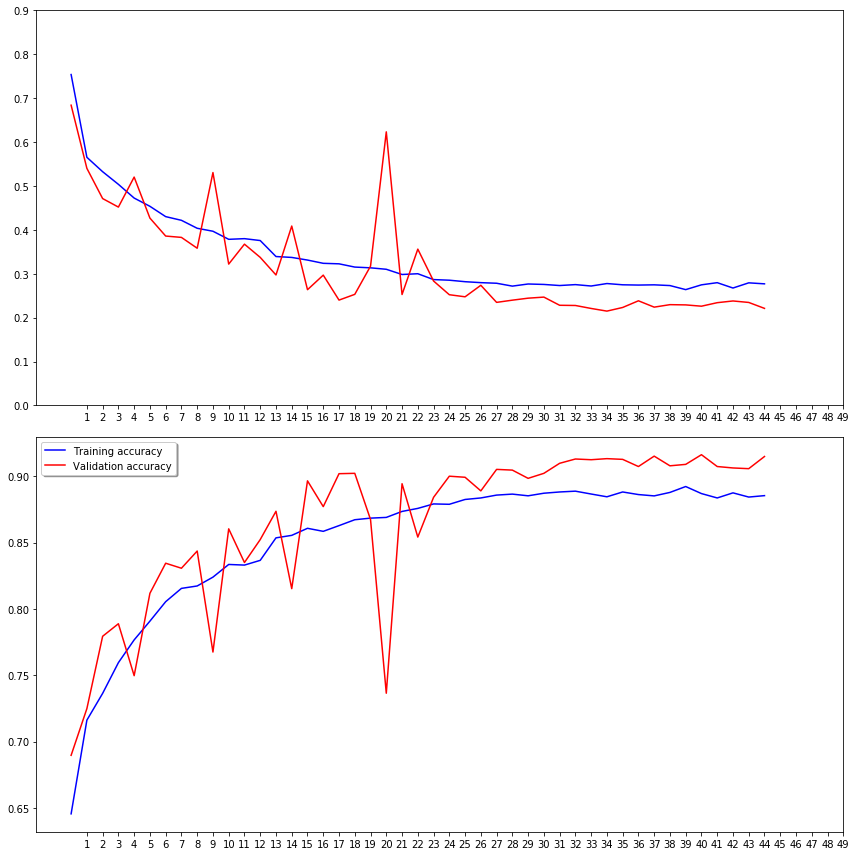

In [21]:

#Virtualize Training

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()



In [22]:

#Prepare Testing Data

test_filenames = os.listdir("../CNN/test1/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]



In [23]:

#Create Testing Generator

test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "../CNN/test1/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)



Found 12500 validated image filenames.


In [24]:

#Predict

predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))



In [25]:


#For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max

test_df['category'] = np.argmax(predict, axis=-1)



In [26]:


#We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [27]:


#From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })



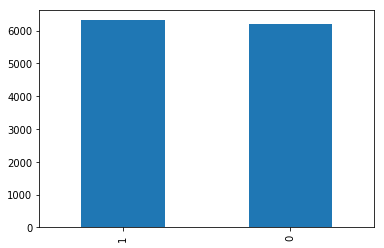

In [28]:

#Virtaulize Result

test_df['category'].value_counts().plot.bar()



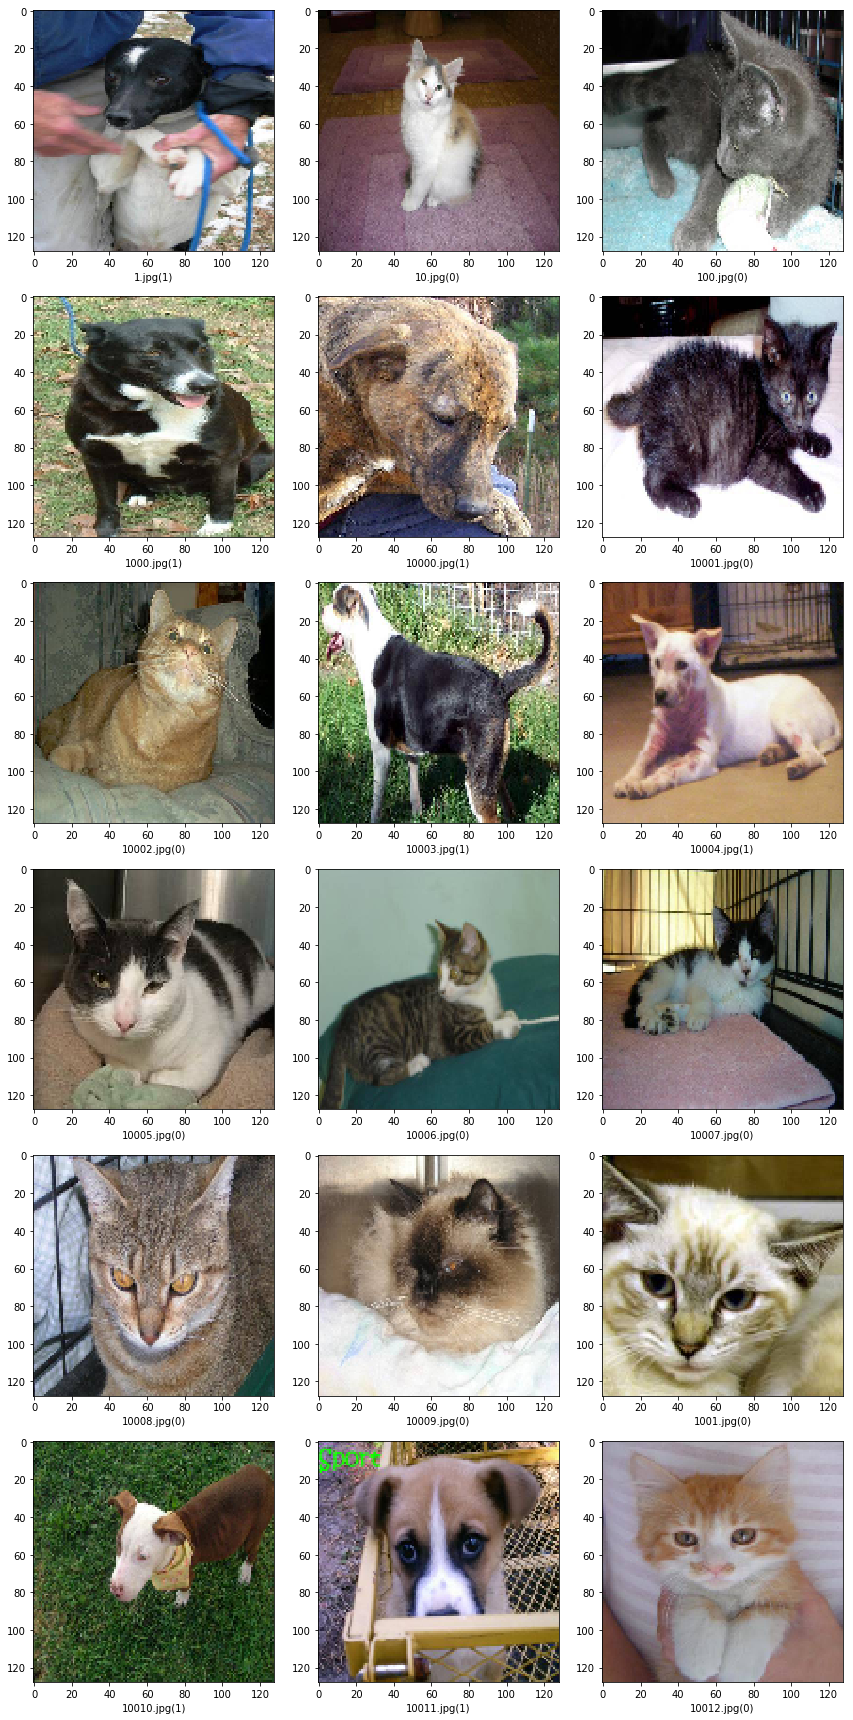

In [29]:

#See predicted result with images

sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("../CNN/test1/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()



In [30]:

#Submission

submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

